In [4]:
''' Test model '''

' Test model '

In [1]:
import models
import importlib
importlib.reload(models)
from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_name = "model_job3"
epoch=96
fp=f"/Users/huayinluo/Documents/code/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
model, optimizer, epoch, loss, batch_size, lr, focal_loss_weights = load_checkpoint(model, optimizer, fp)
model = model.eval()

In [3]:
from dataset import SliceDataset
import numpy as np
import os

data_dir = "data/small_data_256"
x_train_dir = os.path.join(data_dir, "original/train")
y_train_dir = os.path.join(data_dir, "ground_truth/train")
x_test_dir = os.path.join(data_dir, "original/test")
y_test_dir = os.path.join(data_dir, "ground_truth/test")

depth, height, width = np.load(os.path.join(x_train_dir, os.listdir(x_train_dir)[0])).shape
train_dataset = SliceDataset(x_train_dir, y_train_dir,  augment=False)
valid_dataset = SliceDataset(x_test_dir, y_test_dir)

torch.Size([1, 1, 5, 256, 256]) torch.Size([1, 2, 5, 256, 256])


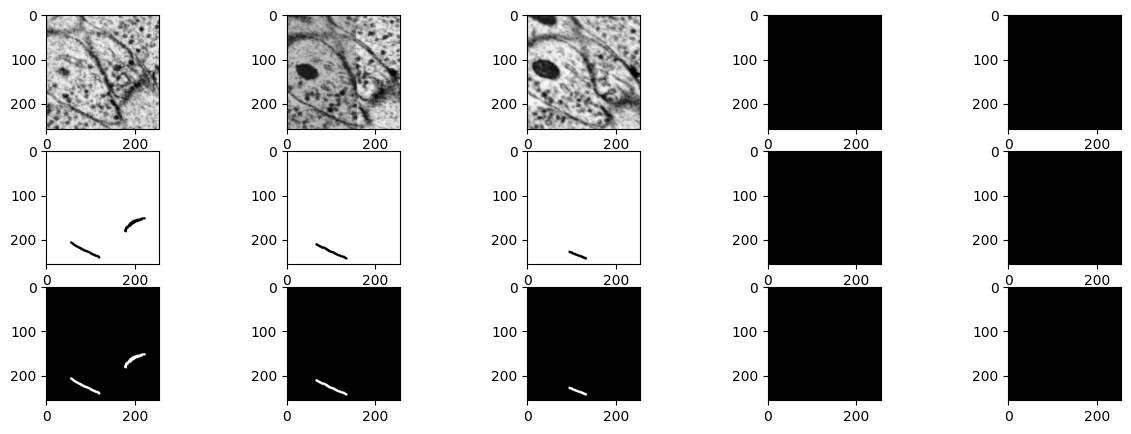

In [9]:
from visualize import visualize_3d_slice
import matplotlib.pyplot as plt
k = 0
inputs, labels = valid_dataset[k] # 0 is gap junction, 1 is non-gap junction
inputs = inputs.unsqueeze(0)
labels = labels.unsqueeze(0)
print(inputs.shape, labels.shape)
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
visualize_3d_slice(inputs[0, 0], ax[0])
visualize_3d_slice(labels[0, 0], ax[1])
visualize_3d_slice(labels[0, 1], ax[2])
plt.show()


In [10]:
# takes ~ 30s to run
pred = model(inputs)
print(pred.shape)

torch.Size([1, 2, 5, 256, 256])


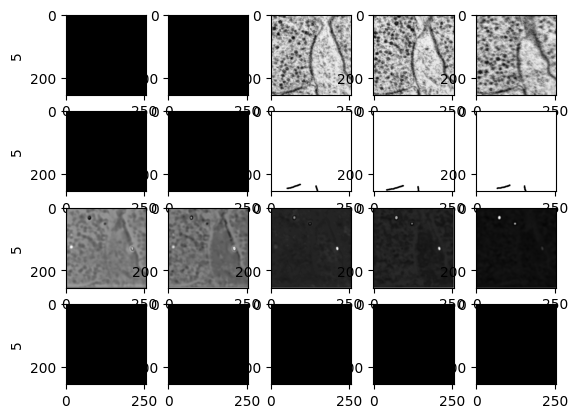

In [19]:
from visualize import *
input_img = inputs[0, 0].numpy()
label_img = labels[0, 0].numpy()
pred_img = pred[0, 1].detach().numpy()
pred_binary = torch.argmax(pred, dim=1).numpy()[0]
depth, height, width = input_img.shape
fig, ax = plt.subplots(4, depth)
visualize_3d_slice(input_img, ax[0], depth)
visualize_3d_slice(label_img, ax[1], depth)
visualize_3d_slice(pred_img, ax[2], depth)
visualize_3d_slice(pred_binary, ax[3], depth)

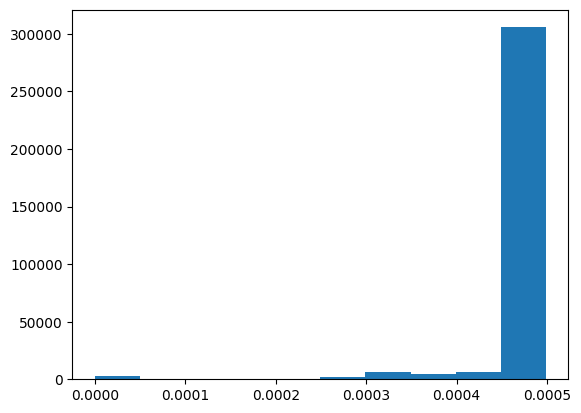

In [ ]:
plt.hist(pred_img.flatten())
plt.show()